In [11]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [52]:
CUR_DIR= os.getcwd()
DATA_DIR = os.path.join(CUR_DIR, "Data")
input_file = os.path.join(DATA_DIR, 'Rushabh.txt')

In [53]:
def startsWithDateAndTime(s):
    # regex pattern for date
    pattern = '^[0-9]{1,2}/[0-9]{1,2}/[0-9]{1,2}, [0-9]{1,2}:[0-9]{1,2} (AM|PM) -'
    #pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (AM|PM) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [54]:
# Finds username of any given format.
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False
  

In [55]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [56]:
parsedData = []
with open(input_file, encoding="utf-8") as f:
    f.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = f.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [57]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])
df.tail()

,Date,Time,Author,Message
15342,2020-12-08,7:03 PM,Rushabh Oswal,Outof 200
15343,2020-12-08,7:03 PM,sushil,Aab nahi dete wo😂
15344,2020-12-08,7:03 PM,Rushabh Oswal,Ok 👍
15345,2020-12-10,11:21 AM,Rushabh Oswal,<Media omitted>
15346,2020-12-10,11:29 AM,sushil,Shit😂😂


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15347 entries, 0 to 15346
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     15347 non-null  datetime64[ns]
 1   Time     15347 non-null  object        
 2   Author   15346 non-null  object        
 3   Message  15347 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 479.7+ KB


In [59]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15346 entries, 0 to 15346
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     15346 non-null  datetime64[ns]
 1   Time     15346 non-null  object        
 2   Author   15346 non-null  object        
 3   Message  15346 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 599.5+ KB


In [60]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [61]:
total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
df

,Date,Time,Author,Message,emoji,urlcount
0,2017-10-01,5:12 PM,sushil,There?,[],0
1,2017-10-01,5:19 PM,Rushabh Oswal,Bol,[],0
2,2017-10-01,5:21 PM,sushil,Me 30th ko lera hu firse date gre ki,[],0
3,2017-10-01,5:21 PM,sushil,Mene kal diya exam 313 hi aaye merko,[],0
4,2017-10-01,5:21 PM,sushil,Toh sochra hu postpone karu,[],0
...,...,...,...,...,...,...
15342,2020-12-08,7:03 PM,Rushabh Oswal,Outof 200,[],0
15343,2020-12-08,7:03 PM,sushil,Aab nahi dete wo😂,[😂],0
15344,2020-12-08,7:03 PM,Rushabh Oswal,Ok 👍,[👍],0
15345,2020-12-10,11:21 AM,Rushabh Oswal,<Media omitted>,[],0


In [62]:
print("total_messages:",total_messages)
print("media_messages:",media_messages)
print("emoji:",emojis)
print("links",links)

total_messages: 15346
media_messages: 540
emoji: 6252
links 159


In [63]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)

In [64]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [65]:
messages_df

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count
0,2017-10-01,5:12 PM,sushil,There?,[],0,6,1
1,2017-10-01,5:19 PM,Rushabh Oswal,Bol,[],0,3,1
2,2017-10-01,5:21 PM,sushil,Me 30th ko lera hu firse date gre ki,[],0,36,9
3,2017-10-01,5:21 PM,sushil,Mene kal diya exam 313 hi aaye merko,[],0,36,8
4,2017-10-01,5:21 PM,sushil,Toh sochra hu postpone karu,[],0,27,5
...,...,...,...,...,...,...,...,...
15341,2020-12-08,7:03 PM,Rushabh Oswal,CET ka score ata na,[],0,19,5
15342,2020-12-08,7:03 PM,Rushabh Oswal,Outof 200,[],0,9,2
15343,2020-12-08,7:03 PM,sushil,Aab nahi dete wo😂,[😂],0,17,4
15344,2020-12-08,7:03 PM,Rushabh Oswal,Ok 👍,[👍],0,4,2


In [66]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
    # Filtering out messages of particular user
    req_df= messages_df[messages_df["Author"] == l[i]]
    # req_df will contain messages of only one particular user
    print(f'Stats of {l[i]} -')
    # shape will print number of rows which indirectly means the number of messages
    print('Messages Sent', req_df.shape[0])
    #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Words per message', words_per_message)
    #media conists of media messages
    media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
    print('Media Messages Sent', media)
    # emojis conists of total emojis
    emojis = sum(req_df['emoji'].str.len())
    print('Emojis Sent', emojis)
    #links consist of total links
    links = sum(req_df["urlcount"])   
    print('Links Sent', links)   
    print()

Stats of sushil -
Messages Sent 7789
Words per message 3.6573372705096934
Media Messages Sent 199
Emojis Sent 3316
Links Sent 21

Stats of Rushabh Oswal -
Messages Sent 7017
Words per message 4.838962519595269
Media Messages Sent 341
Emojis Sent 2936
Links Sent 138



In [67]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

103


In [68]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df


,emoji,count
0,😂,5092
1,👍,195
2,👍🏻,162
3,🔴,68
4,😍,51
...,...,...
98,☹️,1
99,😇,1
100,❗,1
101,💯,1


In [69]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [70]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
    dummy_df = messages_df[messages_df['Author'] == l[i]]
    total_emojis_list = list([a for b in dummy_df.emoji for a in b])
    emoji_dict = dict(Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    print('Emoji Distribution for', l[i])
    author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
    fig = px.pie(author_emoji_df, values='count', names='emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

Emoji Distribution for sushil


Emoji Distribution for Rushabh Oswal


In [71]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 321289 words in all the messages.


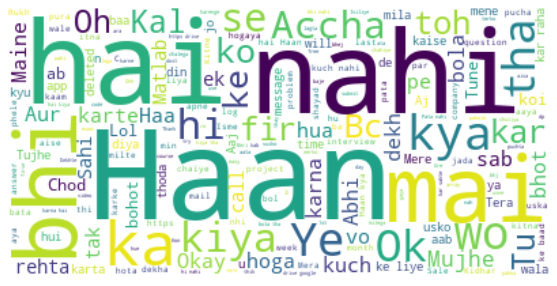

In [72]:
stopwords = set(STOPWORDS)
stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [73]:
messages_df["MessageCount"]=1
messages_df.head(5)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
0,2017-10-01,5:12 PM,sushil,There?,[],0,6,1,1
1,2017-10-01,5:19 PM,Rushabh Oswal,Bol,[],0,3,1,1
2,2017-10-01,5:21 PM,sushil,Me 30th ko lera hu firse date gre ki,[],0,36,9,1
3,2017-10-01,5:21 PM,sushil,Mene kal diya exam 313 hi aaye merko,[],0,36,8,1
4,2017-10-01,5:21 PM,sushil,Toh sochra hu postpone karu,[],0,27,5,1


In [74]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
date_df.head(3)

,Date,urlcount,Letter_Count,Word_Count,MessageCount
0,2017-10-01,0,1084,223,53
1,2017-10-03,0,13,3,2
2,2017-10-04,0,2718,568,116


In [75]:
fig = px.line(date_df, x="Date", y="MessageCount", title='Number of Messages as time moves on.')
fig.update_xaxes(nticks=20)
fig.show()

Text(0, 0.5, 'Date')

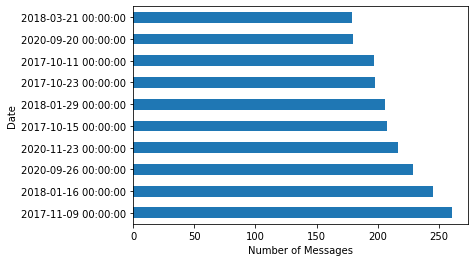

In [76]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')